# Programming Assignment 4: Low Rank Matrix Approximation

<p>
    

<font size="3">

In this assignment, we will use low-rank approximation of matrices, which is useful for finding hidden relationships that might not be apparent from high-dimensional data.


</font>

<hr style="border:3px solid blue"> </hr>

$$
\def\M{\mathsf{M}}
\def\A{\mathsf{A}}
\def\B{\mathsf{B}}
\def\Mhat{\hat{\mathsf{M}}}
\def\O{\mathcal{O}}
\def\OO{\mathsf{O}}
\def\a{\mathbf{a}}
\def\b{\mathbf{b}}
\def\1{\mathbf{1}}
\def\reals{\mathbb{R}}
$$
## Formal definition and notation

<p>

<font size="3"> 
    
In this assignment you will be required to approximate a partially observed (typically) large matrix using a product of low rank matrices. Let us recap the ingredients of low rank matrix approximation: <p>

- Observed matrix $\M$ of size ${m\times n}$ with real valued entries and missing values <p>
    
- Low rank matrices $\A$ of size ${m\times k}$ and $\B$ of size $k \times n$ <p>
    
- We would like to find $\A,\B$ such that $ \M \approx \A \B $. We will denote $\Mhat = \A\B$ <p>
    
We are going to measure the goodness of approximation using the squared error at entries $(i,j)$ for which we know the value of $\M_{ij}$ (entries where the matrix is observed, denoted as $\O = \{(i,j) \mbox{ s.t. } \M_{ij} \mbox{ observed}\}$). Therefore the loss is,
$$
 \mathcal{L} = \frac{1}{|\O|} \sum_{(i,j)\in\O} \! \big(\M_{ij} -  \Mhat_{ij}\big)^2 ~~ (\star) ~.
$$

In [89]:
import matplotlib.pyplot as plt
import numpy as np

# ACT1: Implement average squared loss function. No loops please.
# Given M, M_approx, O return the average squared loss over the observed entries.
# M is an m x n 2-D numpy array containing the observed entries (with
#   arbitrary values in the unobserved entries)
# M_approx is an m x n 2-D numpy array representing the low-dimensional approximation
# O is an m x n 2-D numpy array containing 0 if the entry is unobserved and
#   1 if the entry is observed in M. O tells you which entries in M were observed
def loss(M, M_approx, O):
    ### ACT1: add your code here
    x = O*(M-M_approx)**2
    return (1/np.sum(O)*np.sum(x))

<hr style="border:3px solid blue"> </hr>


## Normalization of M

As the initial prediction of $\Mhat$ would likely to have entries following a standard normal distribution and  we use the squared error as the sole loss, it would be a good practice for us to do normalization for $\M$ prior to the learning process. This means that we will preprocess matrix $\M$ so that the average over its observed entries would be $0$ and the empirical distribution of its entries would resemble a standard normal distribution.   

Mathematically speaking, let us normalize $\M$ such that,
$$\sum_{(i,j)\in\O} M_{ij} = 0 ~ \mbox{ and } ~ \frac{1}{|\O|} \sum_{(i,j)\in\O} M^2_{ij} = 1 ~ .$$
This can be achieve by finding two scalar $a$ and $s$ such that after the transformation,
$\M \mapsto (\M - a) / s$ the matrix is normalized.

Specifically, $a$ and $s$ are the mean and standard deviation of the observed entries in $\M$:
$$a = \frac{1}{|\O|}\sum_{(i,j)\in\O}M_{ij} ~~ \mbox{ and } ~~ s = \sqrt{\frac{1}{|\O|} \sum_{(i,j)\in\O} (M_{ij} - a)^2}$$

In [90]:
# ACT2: return the normalized version of M. No loops please.
# M and O are in the same format as in ACT1
def normalize_matrix(M, O):
    ### ACT2: add your code here
    a1 = np.sum(O)
    a = (1/a1)*np.sum(O*M)
    x = np.sum(O*(M-a)**2)
    s = np.sqrt((1/a1)*x)
    return ((M-a)/s)
# The following functions checks if your implementation of normalize_matrix is correct
# There's no need to understand it
def check_normalization():
    M = np.random.rand(10, 3)
    O = (np.random.rand(10, 3) > 0.5) + 0
    Mn = normalize_matrix(M, O)
    assert(abs(np.sum(Mn * O)) < 1e-6)
    assert(abs(np.sum(Mn**2 * O) / np.sum(O) - 1) < 1e-6)
    print("Function {} is working fine!".format('normalize_matrix'))
    
check_normalization()

Function normalize_matrix is working fine!


<hr style="border:3px solid blue"> </hr>


## Low Rank Matrix Approximation (LORMA) 

We are now ready to build a low rank approximation (abbreviated as *LORMA*) of the form,
$$
\M \approx \Mhat = \A \B  ~ .
$$
For brevitiy we refer to this model as *LORMA*. Note that once we established the approximating matrix $\A$ we can reuse the same function **loss** from above.

In [91]:
# ACT3: implement lorma's prediction. Do not use loops in your implementation.
# A is a m x k numpy 2-D array
# B is a k x n numpy 2-D array
# A and B are the low-rank matrices used to calculate M_approx
def lorma(A, B):
    return (A@B)
    ### ACT3: add your code here

## Gradient of LORMA

Next we need to implement the gradient of the LORMA model. The gradient should have the same structure as the parameters of our LORMA model, which are A (shape m $\times$ k) and B (shape k $\times$ n). 

To get the gradient to A, we apply chain rule for matrix differentiation as: 
$$
\frac{d\mathcal{L}}{d\A} = \frac{d\mathcal{L}}{d\Mhat} \cdot \frac{d\Mhat}{d\A}
$$
where $\frac{d\mathcal{L}}{d\Mhat}$ returns a matrix of a shape of m $\times$ n with its entries:
$$
(\frac{d\mathcal{L}}{d\Mhat})_{ij} = 
                \begin{cases}
                \frac{2}{|\mathcal{O}|}(\Mhat_{ij} - \M_{ij}) & \text{if} (i,j)\in \mathcal{O} \\
                0 & \text{otherwise}
                \end{cases}
$$
and 
$$
\frac{d\Mhat}{d\A} = \B^T
$$
returns a matrix of shape n $\times$ k. Note "$\cdot$" denotes the matrix multiplication.


Likewise, to get the gradient with respect to B, we have 
$$
\frac{d\mathcal{L}}{d\B} = \frac{d\Mhat}{d\B}  \cdot  \frac{d\mathcal{L}}{d\Mhat} ~~~~~~\text{where}~~~~~  \frac{d\Mhat}{d\B} = \A^T
$$

In [96]:
# ACT4: implement lorma gradient. Do not use loops in your implementation.

# Given M, O, A, B return the average squared loss over the observed entries.
# M is an m x n 2-D numpy array containing the observed entries (with
#   arbitrary values in the unobserved entries)
# O is an m x n 2-D numpy array containing 0 if the entry is unobserved and
#   1 if the entry is observed in M. O tells you which entries in M were observed
# You would need to return two matrices as the gradients: dA & dB. dA has m x k, and dB has shape k x n.

def lorma_grad(M, O, A, B):
    ### ACT4: add your code here
    dA = (2/np.sum(O))*((O*(lorma(A,B)-M)@np.transpose(B)))
    dB = (2/np.sum(O))*(np.transpose(A)@(O*(lorma(A,B)-M)))
    return dA, dB

## Initialization of LORMA

<p>

<font size=3>
    
Before we start learning using GD, we need to setup an initial state of $\A$ and $\B$ for estimating $\Mhat$. Recall that we normalized $\M$ such that,
$$\sum_{(i,j)\in\O} M_{ij} = 0 ~ \mbox{ and } ~ \frac{1}{|\O|} \sum_{(i,j)\in\O} M^2_{ij} = 1 ~ .$$
We would like to make sure that the similar properties hold for $\Mhat$. 
<br><br>

More specifically, we adopt random initialzation of the entries in $\A$ and $\B$ followed by a normalization process to make $\Mhat$ satisfy the following properties:  
1. Zero mean, i.e., $\sum_{(i,j)\in\O} \Mhat_{ij} = 0$:
    
  We can write $\Mhat_{ij} = \a_i \cdot \b_j$ where $\a_i$ and $\b_j$ are the i'th row & j'th column of $\A$ and $\B$ respectively. Since $\A$ and $\B$ are completely random the probability that $\a_i\cdot\b_j$ is small is pretty high so we can assume that $\sum_{i,j} \Mhat_{ij} = \sum_{i,j} \a_i \cdot \b_j \approx 0$. 


2. Less than or equal to unit variance, i.e., $\frac{1}{mn} \sum_{i,j} \Mhat_{ij}^2  \leq 1 ~ .$:    
    
  It suffices to have $|\Mhat_{ij}|\leq 1$ to satisfy the above condition. 
  Let us normalize each $\a_i$ and $\b_j$ so they have a unit norm:
$$
    \a_i \mapsto \frac{\a_i}{\|\a_i\|} ~ \mbox{ and } ~ 
    \b_j \mapsto \frac{\b_j}{\|\b_j\|} ~ .
$$
Once the norm of all vectors $\a_1,\ldots,\a_k,\b_1,\ldots,\b_k$ is $1$ the inner products $\a_i\cdot\b_j$ are in $[-1,1]$, which is essentially equivalent to $|\Mhat_{ij}|\leq 1$. This property is known as Cauchy's inequality which is typically presented as,
$|\a\cdot\b| \leq \|\a\| \|\b\|$. 

</font>

In [97]:
# ACT5: implement initialization in accordance to the guidlines above. Do not use loops in your implementation.
# m, n, and k refer to the shapes of A and B
def lorma_init(m, n, k):
    # ACT5: add your code here
    # ACT5a: intialize A, B using a zero-mean unit-variance Gaussian per entry
    A = np.random.randn(m,k)
    B = np.random.randn(k,n)
    # ACT5b: normalize the tow of A and columns of B
    A = A/np.sqrt(np.sum(A*A, axis = 1))[:,None]
    B = B/np.sqrt(np.sum(B*B, axis = 0))[None,:]
    return A, B

def check_lorma_init():
    A, B = lorma_init(10, 7, 3)
    assert(np.linalg.norm(np.diag(A @ A.T) - np.ones(10), 1) < 1e-6)
    assert(np.linalg.norm(np.diag(B.T @ B) - np.ones(7), 1) < 1e-6)
    return

check_lorma_init()

<hr style="border:3px solid blue"> </hr>


## Finally, it is time to use gradient descent (GD) to learn a LORMA model


<font size=3>
    
Details for implementation:
- We provide the way parsing of params should be performed
- The first step is to create A & B by calling lorma_init
- Next create a list called apperr which will record the approximation error after each update.
  Do so by calling LORMA's loss function. You can initialize apperr with the initial loss.

## Main Loop Implementation:

<font size=3>

- Call lorma_grad with O to get new gradients dA & dB for A and B
- Perform gradient step with the externally provide list of learning rate eta
- Every 10 epochs do:
    - Calculate loss and append it to apperr
    - Print most recent current loss:*print((iter + 1), ': ', apperr[-1].round(4))*

In [98]:
### ACT6: implement GD for LORMA model
# k is an integer stating the rank of your LORMA model
# epochs is an integer stating the number of epochs to run
# eta is a list of floats, with the learning rate for each epoch
#   len(eta) = epochs

def lorma_learn(M, O, params):
    k, epochs, eta = params
    ### ACT6: add your code here
    m, n = M.shape
    A, B = lorma_init(m,n,k)
    apperr = [loss(M,lorma(A,B), O)]
    for e in range(epochs):
        dA, dB = lorma_grad(M, O, A, B)
        A = A - eta[e]*dA
        B = B - eta[e]*dB
        if ((e+1) % 10 == 0):
            apperr.append(loss(M,lorma(A,B),O))
            print((e + 1), ': ', apperr[-1].round(4))
    return A, B, apperr

10 :  0.1885
20 :  0.1168
30 :  0.0851
40 :  0.0669
50 :  0.0555
60 :  0.0479
70 :  0.0426
80 :  0.0387
90 :  0.0359
100 :  0.0337


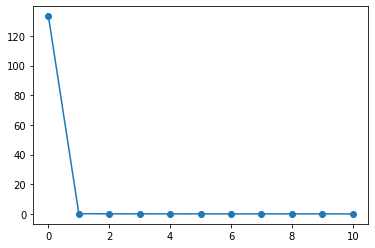

In [74]:
m, n, k = 100, 40, 5
rand_seed = 10
np.random.seed(rand_seed)

def check_lorma_learn():
    from numpy.random import binomial, randn, uniform
    mockA, mockB = uniform(1, 2, (m, k)), uniform(-2, -1, (k, n))
    M = mockA @ mockB + 0.01 * np.random.randn(m, n)
    O = binomial(1, 0.5, size=M.shape)
    epochs = 100
    eta = 2.0 * np.ones(epochs)
    params = k, epochs, eta
    A, B, l = lorma_learn(M, O, params)
    plt.plot(l , '-o')
    return M, A, B

M, A, B = check_lorma_learn()

### Visualizing the data matrix and it low-rank approximation

For reference let us also visualize a random matrix from the same distribution used for initialization. 

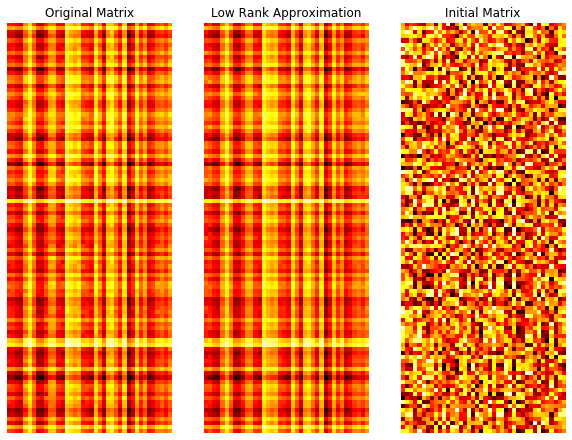

In [75]:
def show_mat(X, str, ind):
    plt.subplot(1,3,ind)
    plt.imshow(X, cmap='hot')
    plt.axis('off')
    plt.title(str)

Ar, Br = lorma_init(m, n, k)
fig = plt.figure(figsize=(10,60))
show_mat(M, 'Original Matrix', 1)
show_mat(lorma(A, B), 'Low Rank Approximation', 2)
show_mat(lorma(Ar, Br), 'Initial Matrix', 3)

<hr style="border:3px solid blue"> </hr>


## Movie Recommendation

In movie recommendation, you are given data about users and their movie preferences, and you have to recommend movies that the users have not seen, and will like. In lecture you learnt about  the [Netflix Prize](https://www.netflixprize.com) which awarded 1 million dollars to a team that  significantly improved their in-house movie recommendation system. An interesting tidbit: the team which finished second in 2008 comprised of three Princeton undergraduates! [[Article]](https://www.cs.princeton.edu/news/article/princeton-undergraduates-challenge-1000000-netflix-prize)
    
We will be using a smaller dataset called [MovieLens](https://grouplens.org/datasets/movielens/).

In [76]:
"""
In this code cell, we will first download the MovieLens data.
We will then convert the data into a matrix form instead of a list form.

The matrix will have people as rows and movies (or Movie IDs) as columns.

We will also download the movie names corresponding to the movie IDs.
"""

# Imports for loading and splitting data
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the MovieLens dataset
# Rows are users and columns are different movies

# Load the data from GitHub
movie_ratings_path = 'https://raw.githubusercontent.com/ameet-1997/Machine-Learning/master/MovieLens/ratings.csv'
movielens_raw = pd.read_csv(movie_ratings_path)

# Process the data to get it in the right format
# The data consists of rows - (userID, movie_ID, rating, timestamp)
# We want to convert it to a matrix where the rows are users and the columns are movies
# We will fill missing values with -1, a value that is not present in the dataset
missing_value = -1
movielens_data = movielens_raw.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(missing_value).to_numpy()

# Create the observed matrix O. It should be boolean matrix with True for observed entries and false otherwise
movielens_observed = (movielens_data != -1) + 0

# We'll convert the boolean matrix to an integer matrix
movielens_observed = movielens_observed.astype(int)

# Let's create a copy of the data because we'll need it later
movielens_data_copy = movielens_data.copy()


# Load the movie names
# The data consists of rows which are movie IDs
movie_names_path = 'https://raw.githubusercontent.com/ameet-1997/Machine-Learning/master/MovieLens/movies.csv'
movie_names = pd.read_csv(movie_names_path)

10 :  1.0159
20 :  1.0074
30 :  0.9996
40 :  0.9921
50 :  0.9848
60 :  0.9776
70 :  0.9703
80 :  0.9629
90 :  0.9552
100 :  0.9471


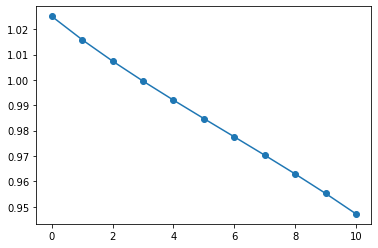

In [77]:
"""
We'll run LORMA on the MovieLens data
"""

rand_seed = 10
np.random.seed(rand_seed)

# Normalize the MovieLens train data
movielens_normalized = normalize_matrix(movielens_data, movielens_observed)
# Define the parameters for LORMA
low_rank = 40
# For debugging run for 100 epochs then switch back to the parameters below
epochs = 100
eta = 10.0 * np.ones(epochs)
params = low_rank, epochs, eta

# Run LORMA
A, B, losses = lorma_learn(movielens_normalized, movielens_observed, params)

# Plot the losses to make sure they are decreasing
_ = plt.plot(losses , '-o')

In [79]:
"""
We'll pick three users and see what movies they liked before, and what movies your model predicted.
Hopefully there is some correlation!

In this cell we first print out some movies that they have liked
"""

# Pick three users to recommend movies to
users = [1,13, 111]

# Let's see their tastes. Print the top-p movies they have rated highly
p = 10
for user in users:
    print("\nUser {} liked the following:\n".format(user))
    
    # Sort the movies for this user in descending order based on the rating
    movie_order = np.argsort(-movielens_data[user])
    top_p = movie_order[:p]
    
    # Print the movies
    for movie in top_p:
        print("\t{:<50} rated {:.1f}  genres {:<30}".format(movie_names.iloc[movie]['title'], movielens_data_copy[user, movie], movie_names.iloc[movie]['genres']))


User 1 liked the following:

	The Final Girls (2015)                             rated 5.0  genres Comedy|Horror                 
	Conan the Barbarian (2011)                         rated 5.0  genres Action|Adventure|Fantasy      
	I'm Still Here (2010)                              rated 5.0  genres Comedy|Drama                  
	The Hungover Games (2014)                          rated 5.0  genres Comedy                        
	Ender's Game (2013)                                rated 5.0  genres Action|Adventure|Sci-Fi|IMAX  
	Zombie Strippers! (2008)                           rated 5.0  genres Comedy|Horror                 
	10,000 BC (2008)                                   rated 4.5  genres Adventure|Romance|Thriller    
	For Richer or Poorer (1997)                        rated 4.5  genres Comedy                        
	Piranha (Piranha 3D) (2010)                        rated 4.5  genres Action|Horror|Thriller        
	Sunshine Cleaning (2008)                           rated 4.5

In [80]:
"""
User 1 seems to like Comedy and Horror
User 13 seems to like Drama and Romance
User 111 seems to like Sci-Fi and Adventure

Now let's make our predictions on the test data and see what movies we can recommend

"""

for user in users:
    print("\nRecommend the following movies to User {}\n".format(user))
    
    # Predict the rating for these movies by performing a matrix multiplication between the user and movie vectors
    predicted_ratings = A[user,:] @ B
    
    # If the movie review was observed in the matrix, set it to (-infinity) so that we don't predict it
    # We want to predict only from a set of movies which the user has not seen
    predicted_ratings[movielens_observed[user]] = -np.inf
    
    # Choose the top_p movies
    predicted_movie_order = np.argsort(-predicted_ratings)
    top_p = predicted_movie_order[:p]
    
    # Print the recommended movies
    for movie in top_p:
        print("\t{:<60} genres {:<30}".format(movie_names.iloc[movie]['title'][:60], movie_names.iloc[movie]['genres']))


Recommend the following movies to User 1

	Passenger 57 (1992)                                          genres Action|Thriller               
	Buffalo '66 (a.k.a. Buffalo 66) (1998)                       genres Drama|Romance                 
	Holiday (Jour de fête) (1949)                                genres Comedy                        
	The Runner (2015)                                            genres Drama                         
	Hotel Transylvania 2 (2015)                                  genres Animation|Comedy              
	Opposite of Sex, The (1998)                                  genres Comedy|Drama|Romance          
	9/11 (2002)                                                  genres Documentary                   
	Nines, The (2007)                                            genres Drama|Mystery                 
	Heist (2001)                                                 genres Crime|Drama                   
	Thief of Bagdad, The (1924)                             

### ACT7: Answer the following question in the cell below and make the "cell type" as markdown

Do you see any correlation between the movies they liked and the predicted movies?

p.s.: The correlation is not strong, but try to see if there is some pattern!

### ACT7:

#### <span style='color:blue'>  Your answer here: I think the biggest correlation we saw was with that every user got the genre they rated highly in their recommondations.  </span>